# Paleontology Machine Learning Project


---

## Explanation 

This project is based on a data base found on https://data.world/bryon/paleobiodb. It is called Paleobilogy Database and is a public database of paleontological data.
This database contains the list of fossiles found on earth with their found locations,descriptions, genuses etc.. 


**What are the main objectives of this project?** 
- study the data attributes to estimate which factors are most important when determining the identity of a given fossil sample.
- test multiple machine learning algorithm to predict the genus of a fossile according to its features.
- compare efficiency/accuracy of those algorithms to understand which algorithm is best fitted for this type of machine learning problem.

---


## Glossary <a id='glossary'></a>
 0) [Processing data](#processing_data)
 1) [KNN with 3 genuses](#processing_data)
 2) [KNN in 3D](#knn3d)
 3) [Logistic regression](#logistic_regression)
 4) [Decision tree](#decision_tree)
 5) [PCA for higher dimensions](#pca)

(you can click on the links to jump directly to each subpart)

---

#### Import libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#Import stuff for k-nearest neighbor 
import sklearn.neighbors
import sklearn.linear_model
from sklearn.utils import shuffle
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
#from mpl_toolkits.basemap import Basemap


#import google.colab
#from google.colab import files
#uploaded = files.upload()

---

## 0) Processing data <a id='processing data'> </a>

In [3]:
data = pd.read_csv('thegigafile.csv')

In [4]:
#Vizualising data 
data

,max_ma,min_ma,genus,lng,lat,paleolng,paleolat,lithology1,composition
0,353.8,345.3,Australosutura,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
1,353.8,345.3,Carbonocoryphe,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
2,353.8,345.3,Thigriffides,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
3,353.8,345.3,Pudoproetus,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
4,353.8,345.3,Pudoproetus,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
...,...,...,...,...,...,...,...,...,...
743654,99.6,93.5,Lepicerus,96.720001,26.360001,105.50,8.29,amber,chitin
743655,468.1,460.9,Eremotoechia,-86.784721,33.311111,-114.63,-8.13,"""limestone""",low Mg calcite
743656,467.3,458.4,Eremotoechia,-84.129166,35.741669,-112.38,-10.30,"""limestone""",low Mg calcite
743657,467.3,458.4,Eremotoechia,-84.125000,35.750000,-112.37,-10.29,"""limestone""",low Mg calcite


In [5]:
print(len(data.columns))

9


---
## 1) K-nearest neighbor (Space/Genus)


The first model we will implement will be a kNN model in 2 dimensions: longitude and lattitude. Then we will try using paleolongitude and paleolattitude to compare.

#### [Jump back to glossary](#glossary)

### a) Data sampling

In [6]:
#Test here on only three data frame
new_table = data[['lng', 'lat', 'genus']].copy()

In [7]:
new_table

,lng,lat,genus
0,-98.099998,31.000000,Australosutura
1,-98.099998,31.000000,Carbonocoryphe
2,-98.099998,31.000000,Thigriffides
3,-98.099998,31.000000,Pudoproetus
4,-98.099998,31.000000,Pudoproetus
...,...,...,...
743654,96.720001,26.360001,Lepicerus
743655,-86.784721,33.311111,Eremotoechia
743656,-84.129166,35.741669,Eremotoechia
743657,-84.125000,35.750000,Eremotoechia


### b) Using k-nearest neighbor with 3 genuses 

#### i) Look at the most occurences of genuses 

In [45]:
genus_counts = new_table['genus'].value_counts().reset_index()
genus_counts.columns = ['genus', 'count']
genus_counts = genus_counts.sort_values(by='count', ascending=False)

# Print the ranking
print("Ranking of genera with the most occurrences:")
for index, row in genus_counts.iterrows():
    print(f"{index+1}. {row['genus']}: {row['count']} occurrences")

Ranking of genera with the most occurrences:
1. Ostrea: 1828 occurrences
2. Composita: 1722 occurrences
3. Chlamys: 1531 occurrences
4. Inoceramus: 1368 occurrences
5. Derbyia: 1330 occurrences
6. Panderodus: 1316 occurrences
7. Nuculana: 1256 occurrences
8. Polygnathus: 1184 occurrences
9. Cleiothyridina: 1172 occurrences
10. Modiolus: 1120 occurrences
11. Favosites: 1092 occurrences
12. Atrypa: 1092 occurrences
13. Ozarkodina: 1081 occurrences
14. Dentalium: 1080 occurrences
15. Anomia: 1076 occurrences
16. Hustedia: 1075 occurrences
17. Glycymeris: 1052 occurrences
18. Bairdia: 1021 occurrences
19. Lingula: 1008 occurrences
20. Isotelus: 1001 occurrences
21. Linoproductus: 995 occurrences
22. Astarte: 957 occurrences
23. Plagiostoma: 941 occurrences
24. Porites: 923 occurrences
25. Neospirifer: 869 occurrences
26. Camptonectes: 852 occurrences
27. Palaeoneilo: 847 occurrences
28. Corbula: 846 occurrences
29. Euspira: 838 occurrences
30. Nucula: 837 occurrences
31. Platystrophia: 830

#### ii) create kNN classification on a small data subset 

In [48]:
filtered_table = new_table[new_table['genus'].isin(['Eremotoechia', 'Pudoproetus', 'Carbonocoryphe'])]
filtered_table = filtered_table.sample(frac=1).reset_index(drop=True)
len(filtered_table)

38

In [11]:
#plotting function 
def plot_scatter(color_map, data_set, x_column, y_column, group_column):
    plt.figure(figsize=(10, 6))
    for group, group_data in data_set.groupby(group_column):
        plt.scatter(group_data[x_column], group_data[y_column], label=group, color=color_map.get(group, 'black'))
    
    plt.xlabel(x_column.capitalize())
    plt.ylabel(y_column.capitalize())
    plt.title(f'Scatter Plot of {x_column.capitalize()} vs {y_column.capitalize()}')
    plt.legend()
    plt.show()

In [12]:
#knn -classification function 
def knn_classification(data, features, target, test_size=0.2, n_neighbors=5):
    # Split the data into features (X) and target (y)
    X = data[features]
    y = data[target]
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Initialize the KNN classifier
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the model
    model.fit(x_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(x_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy


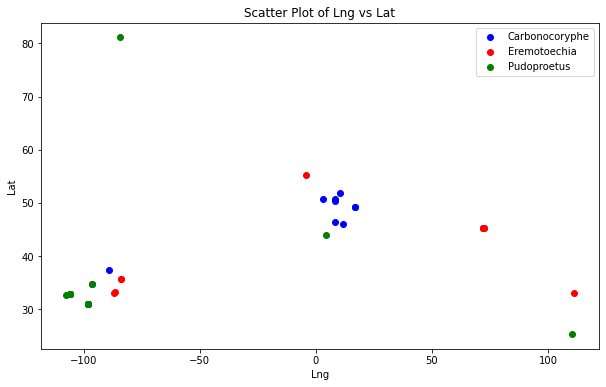

In [13]:
color_map = {
    'Carbonocoryphe': 'blue',
    'Pudoproetus': 'green',
    'Eremotoechia': 'red'
}
plot_scatter(color_map, filtered_table, 'lng', 'lat', 'genus')


##### Decision boundary for k = 3 

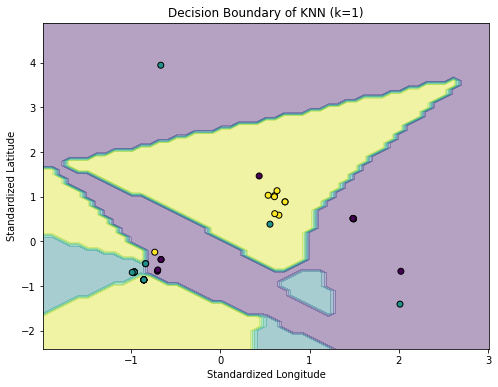

In [14]:
X = filtered_table[['lng', 'lat']]
y = filtered_table['genus']

y = filtered_table['genus'].replace({'Carbonocoryphe': 2,'Pudoproetus': 1, 'Eremotoechia': 0})
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and train the k-nearest neighbors classifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_scaled, y)


# Plot the decision boundary
h = 0.1  # step size in the mesh
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Standardized Longitude')
plt.ylabel('Standardized Latitude')
plt.title('Decision Boundary of KNN (k=1)')
plt.show()

In [58]:
accuracy = knn_classification(filtered_table, ['lng', 'lat'], 'genus', test_size=0.2, n_neighbors=2)


print("Accuracy:", accuracy)

Accuracy: 0.625


#### iii) kNN classification on bigger data

In [16]:
filtered_table2 = new_table[new_table['genus'].isin(['Ostrea', 'Composita', 'Chlamys'])]

In [17]:
filtered_table2= filtered_table2.sample(frac=1).reset_index(drop=True)# --> shuffle the rows 
filtered_table2

,lng,lat,genus
0,27.333332,47.783333,Chlamys
1,6.000000,48.000000,Chlamys
2,-103.196999,30.381001,Composita
3,-104.919998,30.969999,Composita
4,5.583333,48.933334,Chlamys
...,...,...,...
5076,22.783333,42.750000,Ostrea
5077,87.455002,23.510000,Ostrea
5078,-96.468613,32.095280,Ostrea
5079,-81.522224,39.866943,Composita


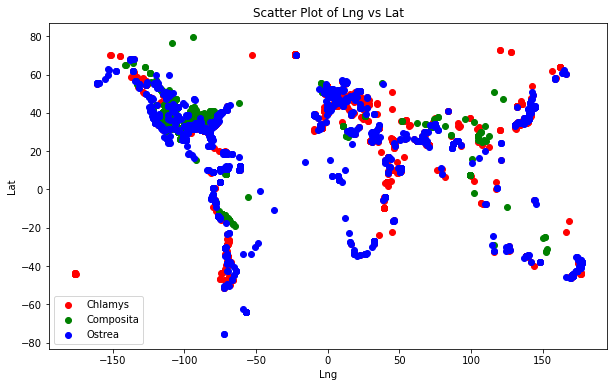

In [18]:
color_map = {
    'Ostrea': 'blue',
    'Composita': 'green',
    'Chlamys': 'red'
}

# Create a scatter plot
plot_scatter(color_map, filtered_table2, 'lng', 'lat', 'genus')


#### iv) Drawing the decision boundary for k =3 

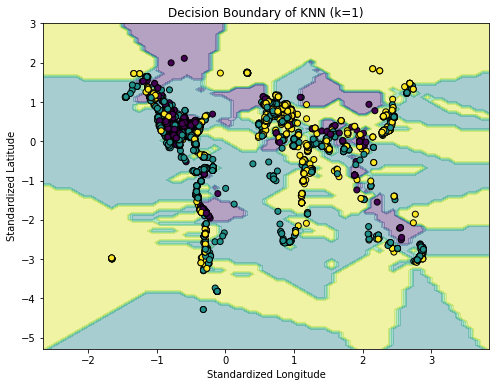

In [19]:
X = filtered_table2[['lng', 'lat']]
y = filtered_table2['genus']

y = filtered_table2['genus'].replace({'Chlamys': 2,'Ostrea': 1, 'Composita': 0})
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and train the k-nearest neighbors classifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_scaled, y)


# Plot the decision boundary
h = 0.1  # step size in the mesh
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Standardized Longitude')
plt.ylabel('Standardized Latitude')
plt.title('Decision Boundary of KNN (k=1)')
plt.show()

In [20]:
accuracy = knn_classification(filtered_table2, ['lng', 'lat'], 'genus', test_size=0.2, n_neighbors=2)


print("Accuracy:", accuracy)

Accuracy: 0.8112094395280236


Very good accuracy at around 80% 

However, there are **major problems**  to such approach : 

- we taking the longitude and latitude of species that may have lived millions years away but maybe at the same place --> time has to be taken into account 

- longitude and latitude in 2D is prone to many errors (example : fossile in Alaska and in Kamchatka are close but in terms of longitude and latitude there are in opposite places)

### c) Expanding kNN to more genuses

### Paleolongitude

In [59]:
paleotable = data[['paleolng', 'paleolat', 'genus']].copy()

In [60]:
filtered_paleotable = paleotable[paleotable['genus'].isin(['Ostrea', 'Composita', 'Chlamys'])]
filtered_paleotable = filtered_paleotable.sample(frac=1).reset_index(drop=True)

In [75]:
accuracy = knn_classification(filtered_paleotable, ['paleolng', 'paleolat'], 'genus', test_size=0.2, n_neighbors=3)
accuracy

0.8485742379547689

---
## 2) k nearest neighbor 3D (Space/ Time/ genuses) <a id='knn3d'></a>

#### [Jump back to glossary](#glossary)

### a) Preprocessing

In this section, we will work on 3D KNN to predict the 10 most common genuses. The first step will be to determine a metric and find a way to renormalize the distances so that KNN doesn't arbitrarily perceive some variables as more important than others.

In [21]:
#defining a new metric for 3D knn using haversine distance and difference in time
from sklearn.metrics.pairwise import haversine_distances
def timespace_metric(X: np.array ,Y: np.array):
    place1=X[:2]
    place2=Y[:2]
    space= haversine_distances([place1],[place2])/np.pi
    time=np.abs(X[-1]-Y[-1])/587.99415
    return (space+time)[0][0]

In [22]:
# checking for the max time difference to renormalize
matrix=data.values
mat=(matrix[:, 0]+matrix[:, 1])/2
M=max(mat)
m=min(mat)
M-m

587.99415

In [23]:
#looks good
timespace_metric(np.array([0,0,0]),np.array([np.pi,0,0]))

1.0

Now that we have a working metric, we will create our data from the large dataset. We decided to only choose 10 genuses to experiment with this, since we were not sure this would generalize well to a large number of genuses. We added a time variable compared to the previous model, we decided to simply average the minimum and the maximum dating of the fossil since this would serve as a good simple data point. We then shuffle the rows to not have any arbitrary bias when choosing the test data set.

In [24]:
#creating the right subdataframe
data3d=data.copy
data3d=data[['lng', 'lat', 'genus']].copy()
data3d['time']=(data['max_ma']+data['min_ma'])/2
data3d = data3d[data3d['genus'].isin(['Ostrea', 'Composita', 'Chlamys','Inoceramus','Derbyia',"Panderodus","Nuculana","Polygnathus","Cleiothyridina","Modiolus"])]
data3d = data3d.sample(frac=1).reset_index(drop=True) # randomize the rows so that there is no bias in the order of the rows
data3d

,lng,lat,genus,time
0,-85.185997,30.437000,Chlamys,18.20500
1,-63.000000,49.500000,Panderodus,446.60000
2,-95.764168,33.839169,Inoceramus,97.20000
3,-79.448059,33.908890,Nuculana,68.30000
4,-103.144997,30.346001,Composita,297.20000
...,...,...,...,...
13822,-113.550003,31.299999,Ostrea,0.06885
13823,-84.959167,36.915833,Cleiothyridina,345.15000
13824,-111.551392,45.915558,Cleiothyridina,365.55000
13825,-80.629997,-5.200000,Ostrea,31.15000


Now we create the model as a callable function so we can experiment with certain variables like number of neighbors, importance of time with respect to space, and vary the test_size as well.

In [86]:
def train3dknn(timespaceratio,neighbors=5,test_size=100,shuffle=False,features=['lng', 'lat','time'],data=data3d):
    #timespaceratio is time_importance/space_importance
    def timespace_metric_in(X: np.array ,Y: np.array):
        place1=X[:2]
        place2=Y[:2]
        space= haversine_distances([place1],[place2])/np.pi
        time=np.abs(X[-1]-Y[-1])/587.99415
        return (space+timespaceratio*time)[0][0]
    
    total_rows=len(data)
    # Select the indices for training and testing sets
    train_indices_3D = list(range(total_rows - test_size))  # Use all rows except the last 10 for training
    test_indices_3D = list(range(total_rows - test_size, total_rows))  # Use the last 10 rows for testing

    data3dknn=data.copy()
    if shuffle:
        data3dknn = data3dknn.sample(frac=1).reset_index(drop=True)
    
    # Split the DataFrame into training and testing sets
    x_train_3D = data3dknn.iloc[train_indices_3D][features]  # Assuming 'lng' and 'lat' are the features
    y_train_3D = data3dknn.iloc[train_indices_3D]['genus']
    x_test_3D = data3dknn.iloc[test_indices_3D][features]
    y_test_3D = data3dknn.iloc[test_indices_3D]['genus']
    
    
    #try to use k-nearest neighbor on simple data 
    model3d = sklearn.neighbors.KNeighborsClassifier(n_neighbors=neighbors,metric=timespace_metric_in)
    model3d.fit(X=x_train_3D, y=y_train_3D)
    
    # Make predictions on the test set
    y_pred_3D = model3d.predict(x_test_3D)
    
    accuracy3D = accuracy_score(y_test_3D, y_pred_3D)
    return accuracy3D

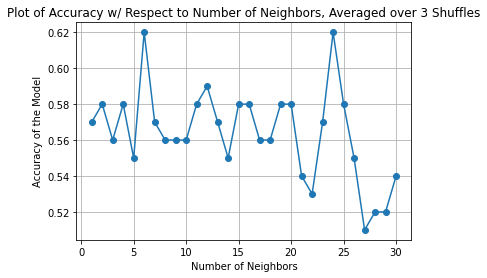

In [87]:
#reshu=[np.average([train3dknn(1,neighbors=i,shuffle=True) for j in range(3)]) for i in range(1,31)]
#reshu (result was rounded)


shuffled_acc_per_neigh= [0.57, 0.58, 0.56, 0.58, 0.55, 0.62, 0.57, 0.56, 0.56, 0.56,
                         0.58, 0.59, 0.57, 0.55, 0.58, 0.58, 0.56, 0.56, 0.58, 0.58,
                         0.54, 0.53, 0.57, 0.62, 0.58, 0.55, 0.51, 0.52, 0.52, 0.54]

# Plotting
plt.plot(np.arange(1,31), shuffled_acc_per_neigh, marker='o')
plt.title('Plot of Accuracy w/ Respect to Number of Neighbors, Averaged over 3 Shuffles')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy of the Model')
plt.grid(True)
plt.show()


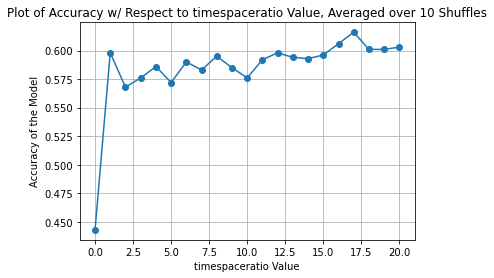

In [88]:
#[np.average([train3dknn(i,neighbors=6,shuffle=True) for j in range(10)]) for i in range(11)]=[0.445, 0.59 , 0.587, 0.621, 0.582, 0.6  , 0.565, 0.592, 0.575,0.588, 0.605]

shuffled_acc_per_timespace=[0.443, 0.598, 0.568, 0.576, 0.586, 0.572, 0.59 , 0.583, 0.595,
       0.585, 0.576, 0.592, 0.598, 0.594, 0.593, 0.596, 0.606, 0.616,
       0.601, 0.601, 0.603]
# Plotting
plt.plot(shuffled_acc_per_timespace, marker='o')
plt.title('Plot of Accuracy w/ Respect to timespaceratio Value, Averaged over 10 Shuffles')
plt.xlabel('timespaceratio Value')
plt.ylabel('Accuracy of the Model')
plt.grid(True)
plt.show()


### b) Visualizing data

#### With 3 genera

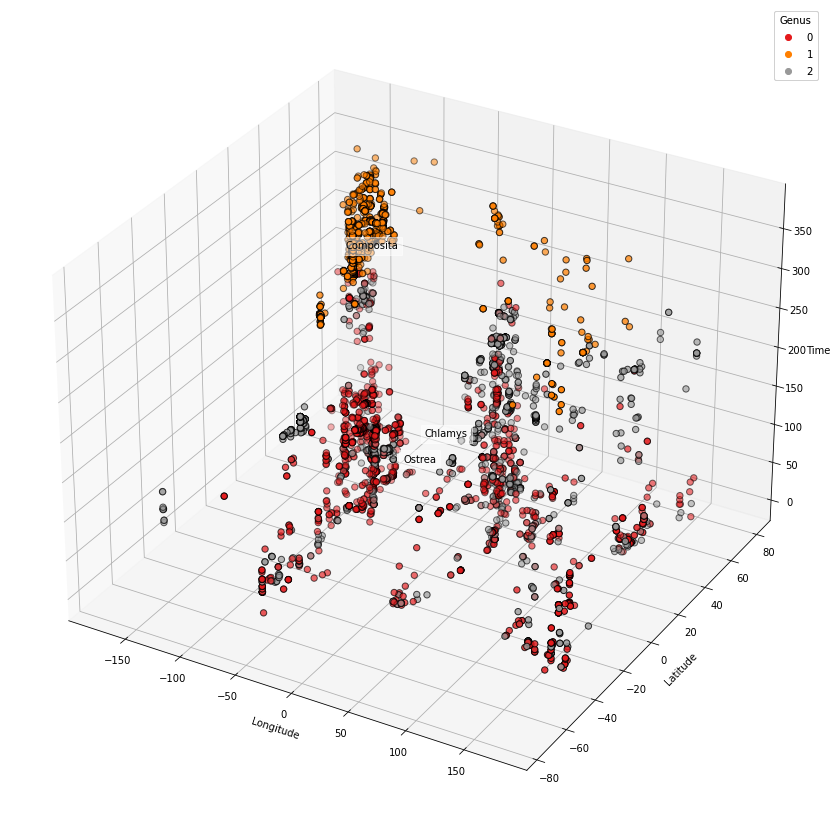

In [89]:
#3D Vizualisation added recently by me --> Oscar :) 

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data3d['lng'], data3d['lat'], data3d['time'], c=data3d['genus'].map({'Ostrea': 0, 'Composita': 1, 'Chlamys': 2}), cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Genus")
ax.add_artist(legend1)


for name, label in [('Ostrea', 0), ('Composita', 1), ('Chlamys', 2)]:
    ax.text3D(data3d[data3d['genus'] == name]['lng'].mean(),
              data3d[data3d['genus'] == name]['lat'].mean(),
              data3d[data3d['genus'] == name]['time'].mean(),
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

plt.show()


#### With 10 genera

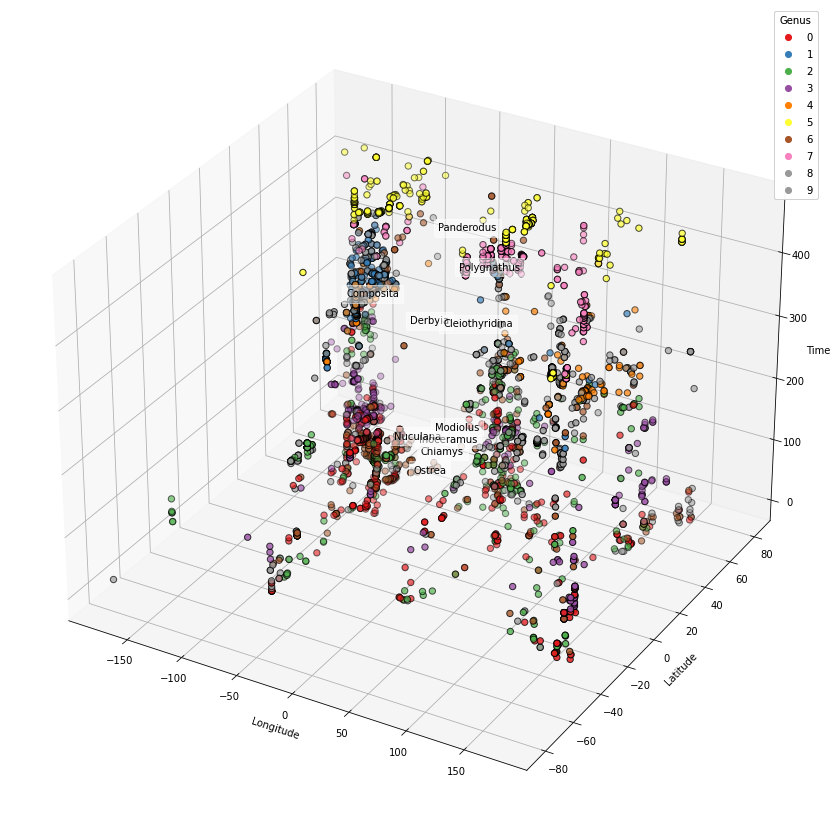

In [90]:
fig = plt.figure(figsize=(20, 15))  # Adjust the size as needed

ax = fig.add_subplot(111, projection='3d')

# Filter data to include only the first 100 occurrences of each genus
filtered_data = pd.concat([data3d[data3d['genus'] == name][:500] for name in ['Ostrea', 'Composita', 'Chlamys', 'Inoceramus', 'Derbyia', 'Panderodus', 'Nuculana', 'Polygnathus', 'Cleiothyridina', 'Modiolus']])

scatter = ax.scatter(filtered_data['lng'], filtered_data['lat'], filtered_data['time'], c=filtered_data['genus'].map({'Ostrea': 0, 'Composita': 1, 'Chlamys': 2, 'Inoceramus':3, 'Derbyia': 4, 'Panderodus': 5, 'Nuculana': 6, 'Polygnathus': 7, 'Cleiothyridina': 8, 'Modiolus': 9}), cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Genus")
ax.add_artist(legend1)

genus_names = ['Ostrea', 'Composita', 'Chlamys', 'Inoceramus', 'Derbyia', 'Panderodus', 'Nuculana', 'Polygnathus', 'Cleiothyridina', 'Modiolus']
for name in genus_names:
    ax.text3D(filtered_data[filtered_data['genus'] == name]['lng'].mean(),
              filtered_data[filtered_data['genus'] == name]['lat'].mean(),
              filtered_data[filtered_data['genus'] == name]['time'].mean(),
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

plt.show()

In [91]:
train3dknn(3)

0.6

### Paleolongitude + Time

In [92]:
# Creating the dataset the exact same way as before
paleodata3d=data.copy
paleodata3d=data[['paleolng', 'paleolat', 'genus']].copy()
paleodata3d['time']=(data['max_ma']+data['min_ma'])/2
paleodata3d = paleodata3d[paleodata3d['genus'].isin(['Ostrea', 'Composita', 'Chlamys','Inoceramus','Derbyia',"Panderodus","Nuculana","Polygnathus","Cleiothyridina","Modiolus"])]
paleodata3d = paleodata3d.sample(frac=1).reset_index(drop=True) # randomize the rows so that there is no bias in the order of the rows
paleodata3d

,paleolng,paleolat,genus,time
0,-7.58,-10.20,Polygnathus,385.200
1,-59.68,-10.19,Cleiothyridina,365.550
2,-18.02,-31.65,Chlamys,186.300
3,51.21,-37.68,Cleiothyridina,257.035
4,-62.78,51.86,Inoceramus,77.850
...,...,...,...,...
13822,142.91,46.46,Ostrea,131.150
13823,-31.85,3.86,Derbyia,270.550
13824,-48.72,-22.93,Panderodus,390.500
13825,-38.73,11.08,Composita,275.800


In [104]:
train3dknn(3,neighbors= 8, features=['paleolat','paleolng','time'],data=paleodata3d)

0.71

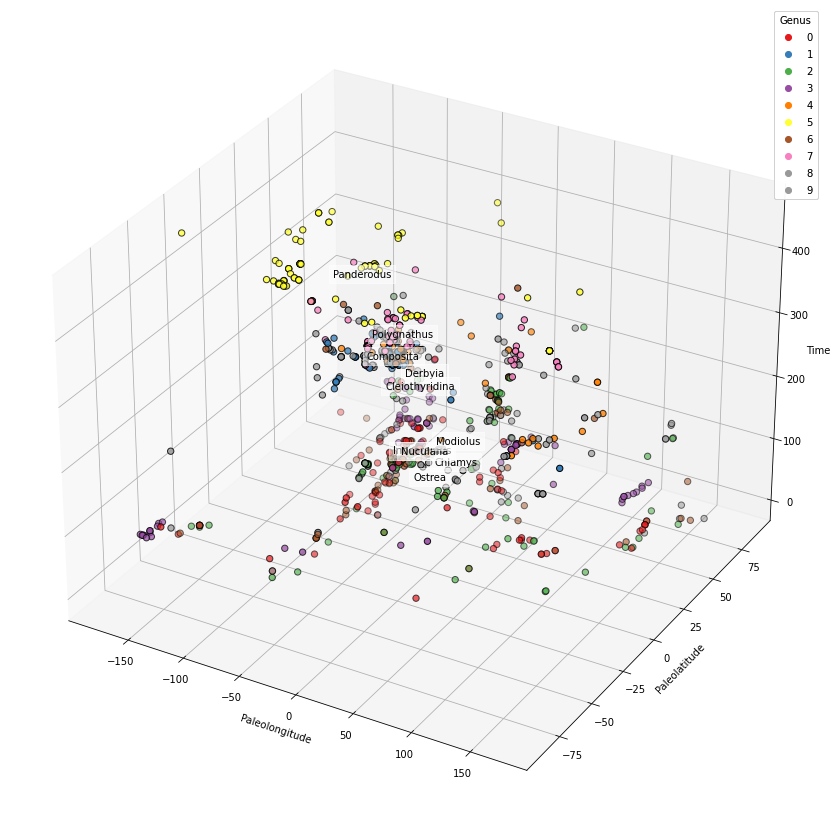

In [107]:
fig = plt.figure(figsize=(20, 15))  # Adjust the size as needed

ax = fig.add_subplot(111, projection='3d')

# Filter data to include only the first 100 occurrences of each genus
filtered_paleodata = pd.concat([paleodata3d[paleodata3d['genus'] == name][:100] for name in ['Ostrea', 'Composita', 'Chlamys', 'Inoceramus', 'Derbyia', 'Panderodus', 'Nuculana', 'Polygnathus', 'Cleiothyridina', 'Modiolus']])

scatter = ax.scatter(filtered_paleodata['paleolng'], filtered_paleodata['paleolat'], filtered_paleodata['time'], c=filtered_paleodata['genus'].map({'Ostrea': 0, 'Composita': 1, 'Chlamys': 2, 'Inoceramus':3, 'Derbyia': 4, 'Panderodus': 5, 'Nuculana': 6, 'Polygnathus': 7, 'Cleiothyridina': 8, 'Modiolus': 9}), cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel('Paleolongitude')
ax.set_ylabel('Paleolatitude')
ax.set_zlabel('Time')

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Genus")
ax.add_artist(legend1)

genus_names = ['Ostrea', 'Composita', 'Chlamys', 'Inoceramus', 'Derbyia', 'Panderodus', 'Nuculana', 'Polygnathus', 'Cleiothyridina', 'Modiolus']
for name in genus_names:
    ax.text3D(filtered_paleodata[filtered_paleodata['genus'] == name]['paleolng'].mean(),
              filtered_paleodata[filtered_paleodata['genus'] == name]['paleolat'].mean(),
              filtered_paleodata[filtered_paleodata['genus'] == name]['time'].mean(),
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

plt.show()

In [108]:
data3d

,lng,lat,genus,time
0,-85.185997,30.437000,Chlamys,18.20500
1,-63.000000,49.500000,Panderodus,446.60000
2,-95.764168,33.839169,Inoceramus,97.20000
3,-79.448059,33.908890,Nuculana,68.30000
4,-103.144997,30.346001,Composita,297.20000
...,...,...,...,...
13822,-113.550003,31.299999,Ostrea,0.06885
13823,-84.959167,36.915833,Cleiothyridina,345.15000
13824,-111.551392,45.915558,Cleiothyridina,365.55000
13825,-80.629997,-5.200000,Ostrea,31.15000


---
# 3) Logistic regression <a id='logistic_regression'></a>

#### [Jump back to glossary](#glossary)

---
# 4) Decision tree <a id='decision_tree'></a>

This section of the project is dedicated to creating a decision tree to attempt to classify each fossil based on criterions.

#### [Jump back to glossary](#glossary)

### a) Data processing

### b) Decision tree

### c) Visualization and results

---
# 5) PCA ? for higher dimensions <a id='pca'></a> 

#### [Jump back to glossary](#glossary)